<a href="https://colab.research.google.com/github/ShyamMuralidharan/Automatic-Ticket-Assignment-NLP/blob/Model-Build/Capstone_Project_Model_Build_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [196]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words("english")) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from sklearn.model_selection import train_test_split
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__
from tensorflow import keras
from keras.layers import InputLayer
from tensorflow.python.keras.layers import Dense, GRU,Embedding,LSTM, Input, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D,TimeDistributed
from tensorflow.python.keras.layers import Dropout
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder



In [198]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [199]:
#### Use when running through google collab
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [0]:
# Please note that this Dataset has 4 more extra columns to identify the language and transilate to English
# Tried this transilation in Python using googletrans API but there is limitation on the numbers of calls, hence 
# googl sheets was used 
df = pd.read_excel(r'/drive/My Drive/Python Files/Capstone Project/processed_trimmed_data.xlsx',sheet_name='Sheet1',encoding="utf-8",dtype="str")

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8379 entries, 0 to 8378
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   trimmed_words_short  8374 non-null   object
 1   trimmed_words_long   8313 non-null   object
 2   Assignment group     8379 non-null   object
 3   new_group_75         8379 non-null   object
 4   new_group_85         8379 non-null   object
 5   new_group_95         8379 non-null   object
dtypes: object(6)
memory usage: 392.9+ KB


In [202]:
df.dtypes

trimmed_words_short    object
trimmed_words_long     object
Assignment group       object
new_group_75           object
new_group_85           object
new_group_95           object
dtype: object

In [203]:
df.head()

,trimmed_words_short,trimmed_words_long,Assignment group,new_group_75,new_group_85,new_group_95
0,login issue,verified user detailsemployee manager name che...,GRP_0,GRP_0,GRP_0,GRP_0
1,outlook,hello team meetingsskype meetings etc appearin...,GRP_0,GRP_0,GRP_0,GRP_0
2,cant log vpn,hi cannot log vpn best,GRP_0,GRP_0,GRP_0,GRP_0
3,unable access hrtool page,unable access hrtool page,GRP_0,GRP_0,GRP_0,GRP_0
4,skype error,skype error,GRP_0,GRP_0,GRP_0,GRP_0


In [204]:
df.describe()

,trimmed_words_short,trimmed_words_long,Assignment group,new_group_75,new_group_85,new_group_95
count,8374,8313,8379,8379,8379,8379
unique,6097,6499,74,10,18,34
top,job job failed jobscheduler,job job failed jobscheduler,GRP_0,GRP_0,GRP_0,GRP_0
freq,438,428,3958,3958,3958,3958


In [205]:
#Confirm that there are no null values in the data set.  This is achieved by using the isnull() function and value counts.
df_null = df.isnull()
df_null.apply(pd.value_counts)

,trimmed_words_short,trimmed_words_long,Assignment group,new_group_75,new_group_85,new_group_95
False,8374,8313,8379.0,8379.0,8379.0,8379.0
True,5,66,NaN,NaN,NaN,NaN


In [0]:
#Confirm that there are no null values in the data set.  This is achieved by using the isnull() function and value counts.
df_null = df.isnull()
df_allnull = df.loc[df_null['trimmed_words_short']==True]+df.loc[df_null['trimmed_words_long']==True]

In [207]:
rows = df_allnull.any(axis=1)
df.iloc[rows.index].head()
#rows.index

,trimmed_words_short,trimmed_words_long,Assignment group,new_group_75,new_group_85,new_group_95
701,printer prtqx wont print anyone office,NaN,GRP_3,GRP_3,GRP_3,GRP_3
1041,reset passwords soldfnbq uhnbsvqd using passwo...,NaN,GRP_17,GRP_9999,GRP_9999,GRP_17
1046,reset passwords fygrwuna gomcekzi using passwo...,NaN,GRP_17,GRP_9999,GRP_9999,GRP_17
1135,reset passwords wvdxnkhf jirecvta using passwo...,NaN,GRP_17,GRP_9999,GRP_9999,GRP_17
1174,reset passwords pxvjczdt kizsjfpq using passwo...,NaN,GRP_17,GRP_9999,GRP_9999,GRP_17


In [0]:
df['trimmed_words_short'] = df['trimmed_words_short'].fillna(df['trimmed_words_long'])
df['trimmed_words_long'] = df['trimmed_words_long'].fillna(df['trimmed_words_short'])

In [209]:
#Confirm that there are no null values in the data set.  This is achieved by using the isnull() function and value counts.
df_null = df.isnull()
df_null.apply(pd.value_counts)

,trimmed_words_short,trimmed_words_long,Assignment group,new_group_75,new_group_85,new_group_95
False,8379,8379,8379,8379,8379,8379


In [210]:
rows = df_allnull.any(axis=1)
df.iloc[rows.index].head()
#rows.index

,trimmed_words_short,trimmed_words_long,Assignment group,new_group_75,new_group_85,new_group_95
701,printer prtqx wont print anyone office,printer prtqx wont print anyone office,GRP_3,GRP_3,GRP_3,GRP_3
1041,reset passwords soldfnbq uhnbsvqd using passwo...,reset passwords soldfnbq uhnbsvqd using passwo...,GRP_17,GRP_9999,GRP_9999,GRP_17
1046,reset passwords fygrwuna gomcekzi using passwo...,reset passwords fygrwuna gomcekzi using passwo...,GRP_17,GRP_9999,GRP_9999,GRP_17
1135,reset passwords wvdxnkhf jirecvta using passwo...,reset passwords wvdxnkhf jirecvta using passwo...,GRP_17,GRP_9999,GRP_9999,GRP_17
1174,reset passwords pxvjczdt kizsjfpq using passwo...,reset passwords pxvjczdt kizsjfpq using passwo...,GRP_17,GRP_9999,GRP_9999,GRP_17


In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8379 entries, 0 to 8378
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   trimmed_words_short  8379 non-null   object
 1   trimmed_words_long   8379 non-null   object
 2   Assignment group     8379 non-null   object
 3   new_group_75         8379 non-null   object
 4   new_group_85         8379 non-null   object
 5   new_group_95         8379 non-null   object
dtypes: object(6)
memory usage: 392.9+ KB


In [0]:
max_features = 10000
maxlen =200
embedding_size = 200
LEARNING_RATE = 1e-3
Units = 100
Drop=0.1
EPOCHS = 2
BATCH_SIZE = 100
#glove=0
numword = 2000
embeddings = {}
embedding_matrix = np.zeros((numword, embedding_size))
t = Tokenizer(num_words=numword)

In [213]:
len(embeddings)

0

In [0]:
def prepare_token(data):
  t = Tokenizer(num_words=numword)
  t.fit_on_texts(data)
  words = pd.DataFrame()
  words["word_index"] = ""
  words["word"] = ""
  words["word_count"] = ""
  i = 0
  for word in t.word_index:
      if not word in stop_words:
         if i<= 1500 :
             new_row = {'word_index':t.word_index[word], 'word':word, 'word_count':t.word_counts[word]}
             words = words.append(new_row, ignore_index=True)
             i = i+1
  words
  return (words)

In [0]:
def prepare_data(X,y):
  df_mod_X=X
  prepare_token(df_mod_X)
  t = Tokenizer(num_words=numword)
  t.fit_on_texts(df_mod_X)
  df_mod_X1 = t.texts_to_sequences(df_mod_X)
  df_mod_X2 = pad_sequences(df_mod_X1, maxlen=200, padding = 'post', truncating = 'post')
  values = y
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(values)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  df_mod_y=onehot_encoded
  #Display the number of groups
  #print(y)
  #a = y.groupby("Assignment group")
  print("Group Count:",len(y.value_counts()))
  Groups = len(y.value_counts())
  # Split features into training and validation sets
  X_train, X_valid, y_train, y_valid = train_test_split(df_mod_X2, df_mod_y, test_size=0.20, random_state=42)
  # Print the share of the training and validation sets
  print("Shape of Training set :",X_train.shape," / ", y_train.shape)
  print("Shape of Validation set :",X_valid.shape," / ", y_valid.shape)
  if glove ==1:
    Glv_model(X)
  return (X_train, X_valid, y_train, y_valid,Groups,embedding_matrix)

In [0]:
def prepare_Model():
  input = Input(shape=(maxlen,)) # Input layer
  if glove==1:
    model = Embedding(t.num_words,embedding_size,weights = [embedding_matrix], input_length=maxlen,trainable = True)(input)
  else:
    model = Embedding(t.num_words,embedding_size, input_length=maxlen,trainable = True)(input)
  model = LSTM(units=Units, return_sequences=True, recurrent_dropout=0.1)(model) # LSTM layer
  model = Flatten()(model)
  model = Dropout(rate=Drop)(model)
  out = Dense(Groups, activation="softmax")(model)  # softmax output layer
  model = Model(input, out) # Complete model
  loss = 'categorical_crossentropy'
  optimizer = tensorflow.keras.optimizers.Adam(lr=LEARNING_RATE)
  model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
  model.summary()
    # Create callback for early stopping on validation loss. If the loss does
  # not decrease on two consecutive tries, stop training
  callbacks = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
  # Train and validate model
  # To start training, call the model.fit method—the model is "fit" to the training data.
  # Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
  history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_valid, y_valid), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)
  return(history)

In [0]:
def Glv_model(data):
  if len(embeddings)==0:
    drive.mount('/content/drive', force_remount=True)
    path = '/content/drive/My Drive/Python Files/Capstone Project/'
    glove_file = path + "glove.6B.zip"
    from zipfile import ZipFile
    with ZipFile(glove_file, 'r') as z:
      z.extractall()
    EMBEDDING_FILE = './glove.6B.200d.txt'
    for o in open(EMBEDDING_FILE):
      word = o.split(" ")[0]
      embd = o.split(" ")[1:]
      embd = np.asarray(embd, dtype='float32')
      embeddings[word] = embd
  print("Glove being used:",len(embeddings))
  EMBEDDING_FILE = './glove.6B.200d.txt'
  t = Tokenizer(num_words=numword)
  t.fit_on_texts(data)
  def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)
  all_embs = np.stack(embeddings_index.values())
  emb_mean,emb_std = all_embs.mean(), all_embs.std()
  embed_size = all_embs.shape[1]
  word_index = t.word_index
  nb_words = numword
  embedding_matrix = np.zeros((nb_words, embedding_size))
  for word, i in word_index.items():
    if i >= nb_words: continue    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
  return(embedding_matrix)

In [0]:
#Plot the Accuracy and Loss on the graph to represent the trend
def plot_history(history):
    fig = plt.figure(figsize = (10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'], label='Train Acc')
    plt.plot(history.history['val_acc'], label='Validation Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()
    
    plt.show()

Group Count: 74
Shape of Training set : (6703, 200)  /  (6703, 74)
Shape of Validation set : (1676, 200)  /  (1676, 74)
Run Count: 1 / MODEL for : trimmed_words_short / Assignment group / Groups : 74
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
lstm_17 (LSTM)               (None, 200, 100)          120400    
_________________________________________________________________
flatten_17 (Flatten)         (None, 20000)             0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 20000)             0         
________________________________________________________

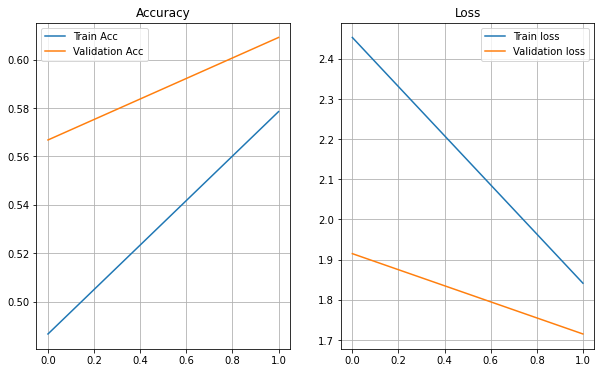

Group Count: 10
Shape of Training set : (6703, 200)  /  (6703, 10)
Shape of Validation set : (1676, 200)  /  (1676, 10)
Run Count: 2 / MODEL for : trimmed_words_short / new_group_75 / Groups : 10
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
lstm_18 (LSTM)               (None, 200, 100)          120400    
_________________________________________________________________
flatten_18 (Flatten)         (None, 20000)             0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 20000)             0         
____________________________________________________________

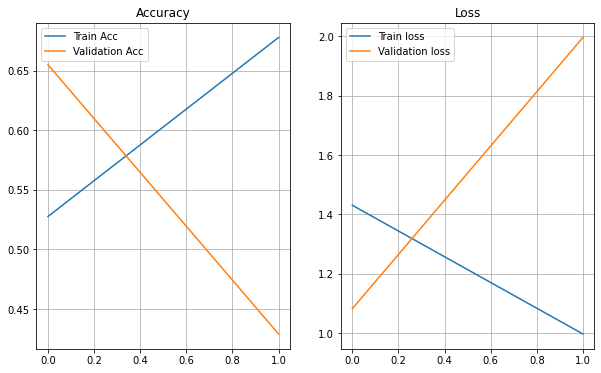

Group Count: 18
Shape of Training set : (6703, 200)  /  (6703, 18)
Shape of Validation set : (1676, 200)  /  (1676, 18)
Run Count: 3 / MODEL for : trimmed_words_short / new_group_85 / Groups : 18
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
lstm_19 (LSTM)               (None, 200, 100)          120400    
_________________________________________________________________
flatten_19 (Flatten)         (None, 20000)             0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 20000)             0         
____________________________________________________________

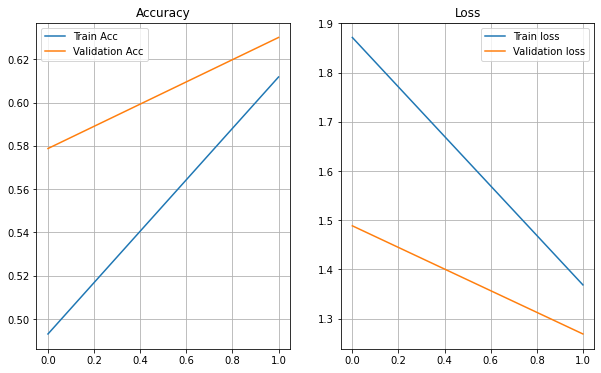

Group Count: 34
Shape of Training set : (6703, 200)  /  (6703, 34)
Shape of Validation set : (1676, 200)  /  (1676, 34)
Run Count: 4 / MODEL for : trimmed_words_short / new_group_95 / Groups : 34
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
lstm_20 (LSTM)               (None, 200, 100)          120400    
_________________________________________________________________
flatten_20 (Flatten)         (None, 20000)             0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 20000)             0         
____________________________________________________________

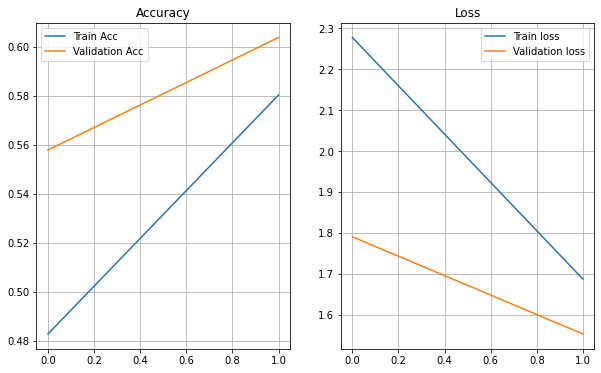

In [219]:
 Dim = ['trimmed_words_short','trimmed_words_long']
 target = ['Assignment group','new_group_75','new_group_85','new_group_95']
 Desc_Col = []
 Group_Col = []
 Dense_group = []
 Train_Acc = []
 Valid_Acc = []
 Train_Loss = []
 Valid_Loss = []
 n=1
 glove=0
 for D in Dim:
   for T in target:
     if n>=5:
       break
     X_train,X_valid,y_train,y_valid,Groups,embedding_matrix = prepare_data(df[D],df[T])
     print("Run Count:",n,"/","MODEL for :",D,"/",T,"/","Groups :",Groups)
     history = prepare_Model()
     Desc_Col.append(D)
     Group_Col.append(T)
     Dense_group.append(Groups)
     Train_Acc.append(round(max(history.history['acc']),2))
     Valid_Acc.append(round(max(history.history['val_acc']),2))
     Train_Loss.append(round(max(history.history['loss']),2))
     Valid_Loss.append(round(max(history.history['val_loss']),2))
     plot_history(history)
     n=n+1


In [221]:
Results =[]
Results = pd.DataFrame(
    { 'Description Col':Desc_Col,
      'Group Col':Group_Col,
      'Dense Group':Dense_group,
      'Training Acc':Train_Acc,
      'Validation Acc':Valid_Acc,
      'Training Loss':Train_Loss,
      'Validation Loss':Valid_Loss
     })
Results

,Description Col,Group Col,Dense Group,Training Acc,Validation Acc,Training Loss,Validation Loss
0,trimmed_words_short,Assignment group,74,0.58,0.61,2.45,1.91
1,trimmed_words_short,new_group_75,10,0.68,0.66,1.43,2.00
2,trimmed_words_short,new_group_85,18,0.61,0.63,1.87,1.49
3,trimmed_words_short,new_group_95,34,0.58,0.60,2.28,1.79
